In [132]:
# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import graphviz

from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_curve, auc

matplotlib.rc("font", family="Malgun Gothic")

# 그래디언트 부스팅
아래는 대출자들의 채무 상환과 관련된 데이터이다.  
상환 여부를 예측하기 위한 그래디언트 부스팅 분석을 실시하고 결과를 해석하시오.  
- 데이터: HMEQ.CSV(변수: 13게, 자료 수: 3,748개)

In [2]:
df_raw=pd.read_csv("../data/HMEQ.csv")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [3]:
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

> Value는 14개의 결측치, JOB은 81개의 결측치, ... 등을 가짐

In [4]:
# JOB 변수의 결측치는 "Other"로 대체
# inplace: fillna 함수 적용 후 df_raw 데이터에 저장, false면 저장 안함
df_raw["JOB"].fillna("Other", inplace=True)
# 숫자형 변수의 결측치는 해당 변수의 평균값 입력: df_raw.mean() 각 변수별 평균 계산 후 결측치 대체
df_raw.fillna(df_raw.mean(), inplace=True)

In [5]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy=pd.get_dummies(df_raw)
# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [6]:
# 목표변수, 설명변수 데이터 지정
df_raw_y=df_raw_dummy["BAD"]
df_raw_x=df_raw_dummy.drop("BAD", axis=1, inplace=False)

In [7]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (2623, 18)
train data Y size : (2623,)
test data X size : (1125, 18)
test data Y size : (1125,)


In [8]:
tree_uncustomized=GradientBoostingClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))


Accuracy on training set: 0.963
Accuracy on test set: 0.941


> 모델 정확도는 train 96.3%, test 94.1%로 선능이 양호하고 유사한 수준

- learning_rate : 학습률 변경에 따른 모델 성능

In [13]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# min_samples_lr: 잎사귀 최소 자료 수
para_lr=[lr*0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb=GradientBoostingClassifier(random_state=1234, learning_rate=v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_lr=pd.DataFrame()
df_accuracy_lr["LearningRate"]=para_lr
df_accuracy_lr["Trainaccuracy"]=train_accuracy
df_accuracy_lr["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_lr.round(3)

,LearningRate,Trainaccuracy,Testaccuracy
0,0.1,0.963,0.941
1,0.2,0.984,0.940
2,0.3,0.994,0.939
3,0.4,0.999,0.944
4,0.5,1.000,0.934
5,0.6,1.000,0.937
6,0.7,1.000,0.941
7,0.8,0.999,0.931
8,0.9,1.000,0.937


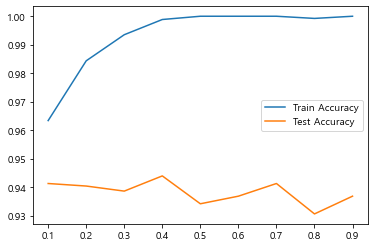

In [14]:
# 모델 정확도 그래프 확인
plt.plot(para_lr, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle="-", label="Test Accuracy")
plt.legend()

> 학습률 증가에 따라 모델의 정확도는 증가하는데  

> test 데이터의 성능은 특별히 개선되지 않아  0.1 선택  

> 0.1~0.2 사이의 세밀한 변화에 따른 성능 확인 필요

- n_estimators: 트리 수 변경에 따른 모델 성능

In [18]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# min_samples_n_tree: 잎사귀 최소 자료 수
para_n_tree=[n_tree*10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb=GradientBoostingClassifier(random_state=1234, n_estimators=v_n_estimators, learning_rate=0.1)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_n_tree=pd.DataFrame()
df_accuracy_n_tree["n_estimators"]=para_n_tree
df_accuracy_n_tree["Trainaccuracy"]=train_accuracy
df_accuracy_n_tree["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_n_tree.round(3)

,n_estimators,Trainaccuracy,Testaccuracy
0,10,0.933,0.928
1,20,0.939,0.932
2,30,0.947,0.936
3,40,0.952,0.940
4,50,0.956,0.940
5,60,0.957,0.940
6,70,0.957,0.939
7,80,0.960,0.939
8,90,0.961,0.940
9,100,0.963,0.941


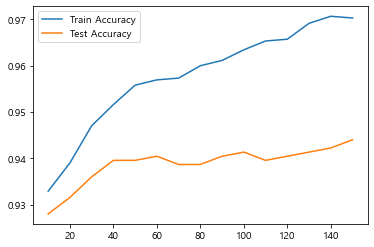

In [19]:
# 모델 정확도 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle="-", label="Test Accuracy")
plt.legend()

> 생성하는 결정 트리 수 증가에 따라 모델의 정확도는 증가하며  

> Train/test 데이터의 성능 변화를 고려하여 100 선택  


- max_depth: 최대 깊이 변경에 따른 모델 성능

In [20]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# min_samples_depth: 잎사귀 최소 자료 수
para_depth=[depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb=GradientBoostingClassifier(random_state=1234, learning_rate=0.1, max_depth=v_max_depth, n_estimators=100)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_depth=pd.DataFrame()
df_accuracy_depth["Depth"]=para_depth
df_accuracy_depth["Trainaccuracy"]=train_accuracy
df_accuracy_depth["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_depth.round(3)

,Depth,Trainaccuracy,Testaccuracy
0,1,0.936,0.935
1,2,0.951,0.940
2,3,0.963,0.941
3,4,0.979,0.945
4,5,0.990,0.940
5,6,0.998,0.949
6,7,1.000,0.947
7,8,1.000,0.948
8,9,1.000,0.950
9,10,1.000,0.947


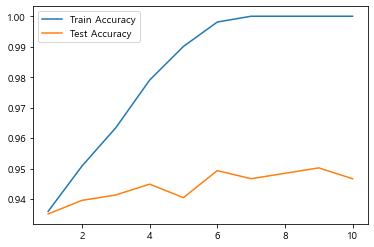

In [21]:
# 모델 정확도 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="-", label="Test Accuracy")
plt.legend()

> 최대 깊이 증가에 따라 모델의 정확도는 증가하며  
> Train/test 데이터의 성능 변화를 고려하여 4 선택

- min_samples_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [23]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# min_samples_split: 잎사귀 최소 자료 수
para_split=[n_split*10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    gb=GradientBoostingClassifier(random_state=1234, learning_rate=0.1, n_estimators=100, min_samples_split=v_min_samples_split, max_depth=4)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_split=pd.DataFrame()
df_accuracy_split["MinSamplesSplit"]=para_split
df_accuracy_split["Trainaccuracy"]=train_accuracy
df_accuracy_split["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_split.round(3)

,MinSamplesSplit,Trainaccuracy,Testaccuracy
0,10,0.977,0.945
1,20,0.976,0.942
2,30,0.974,0.942
3,40,0.973,0.937
4,50,0.969,0.941
5,60,0.973,0.941
6,70,0.969,0.943
7,80,0.968,0.943
8,90,0.966,0.941
9,100,0.963,0.940


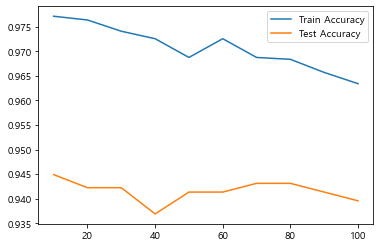

In [24]:
# 모델 정확도 그래프 확인
plt.plot(para_split, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle="-", label="Test Accuracy")
plt.legend()

> 분리 노드의 최소 자료 수 증가에 따라 모델의 정확도는 감소하나  
> train/test 데이터의 성능에 증감이 발생하고 있어 트정 값을 지정하지 않음.

- min_samples_leaf: 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [25]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf=[n_leaf*10 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    gb=GradientBoostingClassifier(random_state=1234, learning_rate=0.1, min_samples_leaf=v_min_samples_leaf,n_estimators=100, max_depth=4)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_leaf=pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"]=para_leaf
df_accuracy_leaf["Trainaccuracy"]=train_accuracy
df_accuracy_leaf["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_leaf.round(3)

,MinSamplesLeaf,Trainaccuracy,Testaccuracy
0,10,0.977,0.946
1,20,0.970,0.942
2,30,0.970,0.942
3,40,0.963,0.940
4,50,0.960,0.942
5,60,0.958,0.939
6,70,0.958,0.937
7,80,0.955,0.940
8,90,0.950,0.936
9,100,0.948,0.938


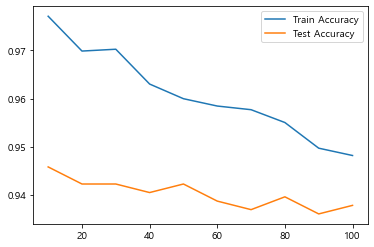

In [26]:
# 모델 정확도 그래프 확인
plt.plot(para_leaf, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle="-", label="Test Accuracy")
plt.legend()

> 잎사귀 노듸의 최소 자료 수 증가에 따라 모델의 정확도는 감소하며  
> Train/test 데이터의 성능 변화를 고려하여 10 선택    
> 20을 선택하면 Train/test 데이터의 성능 차이가 매우 큼


In [27]:
# 최종 모델
gb_final=GradientBoostingClassifier(random_state=1234, min_samples_leaf=10, max_depth=4, n_estimators=100, learning_rate=0.1)
gb_final.fit(df_train_x, df_train_y)

# 예측
y_pred=gb_final.predict(df_test_x)
# train 데이터 셋 정확도
print("Accuracy on training set: {0:.3f}\n".format(gb_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {0:.3f}\n".format(gb_final.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.977

Accuracy on test set: 0.946

Confusion matrix: 
[[1018    3]
 [  58   46]]


> train/test 데이터의 정분류율이 다른 모델 대비 높은 수준이며 데이터 간의 차이도 크지 않음

In [28]:
# 변수명 저장
v_feature_name=df_train_x.columns

# 결론 도출
# gb.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
9,DEBTINC,0.327
6,CLAGE,0.120
2,VALUE,0.107
8,CLNO,0.105
5,DELINQ,0.100
0,LOAN,0.072
1,MORTDUE,0.041
7,NINQ,0.038
4,DEROG,0.034
3,YOJ,0.033


Text(0, 0.5, '변수')

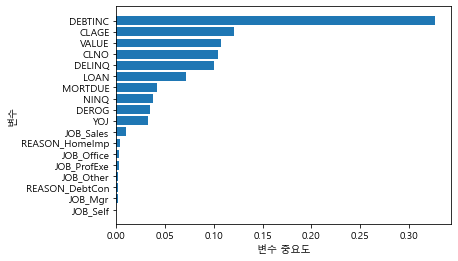

In [29]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

> 중요 설명변수: 트리 생성 시 부채비율(DEBTINC), 최장 계좌 연속월(CLAGE)   
순으로 영향이 크다고 해석할 수 있음  
> (의사결저나무, 랜덤포레스트와 다름)

> 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 훈련 데이터에 따라   
중요도는 변경될 수 있음

- GridSearchCV를 이용한 최적 parameter 찾기

In [65]:
# estimator=GradientBoostingClassifier(random_state=1234)
# # 구하고자 하는 parameter와 범위
# param_grid={"learning_rate":para_lr, "max_depth":para_depth, "min_samples_leaf":para_leaf}
# # 설명력이 높은 최적 parameter 찾기
# grid_gb = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs=-1)
# grid_gb.fit(df_train_x, df_train_y)

# print("best estimator model: \n{}".format(grid_gb.best_estimator_))
# print("\nbest parameter: \n{}".format(grid_gb.best_params_))
# print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))

best estimator model: 
DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=10,
                       random_state=1234)

best parameter: 
{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10}

best score: 
0.897


# 서포트 벡터 머신
아래는 대출자들의 채무 상환과 관련된 데이터이다.  
상환 여부를 예측하기 위한 서포트 벡터 머신 분석을 실시하고 결과를 해석하시오.  
- 데이터: HMEQ.CSV(변수: 13게, 자료 수: 3,748개)

In [31]:
df_raw=pd.read_csv("../data/HMEQ.csv")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [32]:
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

> Value는 14개의 결측치, JOB은 81개의 결측치, ... 등을 가짐

In [33]:
# JOB 변수의 결측치는 "Other"로 대체
# inplace: fillna 함수 적용 후 df_raw 데이터에 저장, false면 저장 안함
df_raw["JOB"].fillna("Other", inplace=True)
# 숫자형 변수의 결측치는 해당 변수의 평균값 입력: df_raw.mean() 각 변수별 평균 계산 후 결측치 대체
df_raw.fillna(df_raw.mean(), inplace=True)

In [34]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy=pd.get_dummies(df_raw)
# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [35]:
# 목표변수, 설명변수 데이터 지정
df_raw_y=df_raw_dummy["BAD"]
df_raw_x=df_raw_dummy.drop("BAD", axis=1, inplace=False)

In [36]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (2623, 18)
train data Y size : (2623,)
test data X size : (1125, 18)
test data Y size : (1125,)


In [38]:
svm_uncustomized=SVC(random_state=1234)
svm_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(svm_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(svm_uncustomized.score(df_test_x, df_test_y)))


Accuracy on training set: 0.908
Accuracy on test set: 0.908


> 모델 정확도는 train 90.8%, test 90.8%로 성능이 양호하고 유사한 수준

- C: 규제에 대한 강도 변경

In [42]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# c: 규제(0.01, 0.1, 1, 10)
para_c=[10**c for c in range(-2, 2)]
#para_c=[c*0.1 for c in range(1, 10)]#C 변화 구간 변경

for v_C in para_c:
    svm=SVC(random_state=1234, C=v_C)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_c=pd.DataFrame()
df_accuracy_c["C"]=para_c
df_accuracy_c["Trainaccuracy"]=train_accuracy
df_accuracy_c["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_c.round(3)

,C,Trainaccuracy,Testaccuracy
0,0.01,0.908,0.908
1,0.10,0.908,0.908
2,1.00,0.908,0.908
3,10.00,0.909,0.908


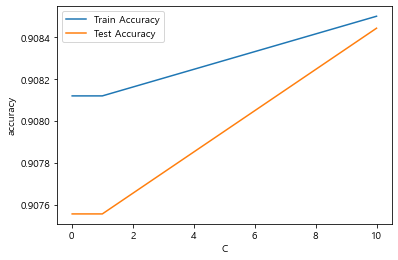

In [46]:
# 모델 정확도 그래프 확인
plt.plot(para_c, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_c, test_accuracy, linestyle="-", label="Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

> C가 1 이상이면 train 데이터 이용한 모델의 정확도는 1(과대적합) test 정확도는 변환 없음  
> C가 0.1~1.0 변화 시 정확도 확인 필요


- Gamma: 훈련 샘플이 미치는 영향의 범위를 변경

In [47]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# c: 규제(0.01, 0.1, 1, 10)
para_gamma=[10**gamma for gamma in range(-2, 2)]
#para_gamma=[c*0.1 for c in range(1, 10)]#C 변화 구간 변경

for v_gamma in para_gamma:
    svm=SVC(random_state=1234, C=0.1, gamma=v_gamma)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_gamma=pd.DataFrame()
df_accuracy_gamma["gamma"]=para_gamma
df_accuracy_gamma["Trainaccuracy"]=train_accuracy
df_accuracy_gamma["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_gamma.round(3)

,gamma,Trainaccuracy,Testaccuracy
0,0.01,0.908,0.908
1,0.10,0.908,0.908
2,1.00,0.908,0.908
3,10.00,0.908,0.908


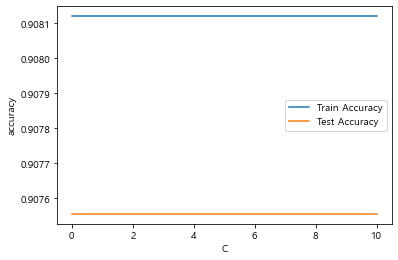

In [48]:
# 모델 정확도 그래프 확인
plt.plot(para_c, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_c, test_accuracy, linestyle="-", label="Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

> gamma 변화는 정확도에 영향을 미치지 않음  

> gamma 변화 구간을 변경하여 정확도 확인 가능


- Standardscaler: 설명변수 값의 구간을 동일하게 변경

In [49]:
# 변수명 저장
v_feauture_name=df_train_x.columns
# StandardScaler 적용
scaler=StandardScaler()
df_scaled=scaler.fit_transform(df_raw_x)
df_scaled=pd.DataFrame(df_scaled, columns=v_feature_name)
df_scaled.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
2,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556
3,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,-1.548549,1.548549,2.618672,-0.446497,-0.828257,-0.574064,-0.131804,-0.189556
4,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556


In [50]:
# 데이터 분할
df_scaled_train_x, df_scaled_test_x=train_test_split(df_scaled, test_size=0.3, random_state=1234)
print("train data X size: {}".format(df_scaled_train_x.shape))
print("test data X size: {}".format(df_scaled_test_x.shape))

train data X size: (2623, 18)
test data X size: (1125, 18)


- scale이 조정된 데이터로 새로운 모델 생성

In [51]:
svm_scaled=SVC(random_state=1234)
svm_scaled.fit(df_scaled_train_x, df_train_y)
# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(svm_scaled.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(svm_scaled.score(df_test_x, df_test_y)))


Accuracy on training set: 0.092
Accuracy on test set: 0.092


- C: 규제에 대한 강도 변경

In [55]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# c: 규제(0.01, 0.1, 1, 10)
para_c=[10**c for c in range(-2, 2)]
#para_c=[c*0.1 for c in range(1, 10)]#C 변화 구간 변경

for v_C in para_c:
    svm=SVC(random_state=1234, C=v_C)
    svm.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x, df_test_y))
    
# 결과 저장
df_accuracy_c=pd.DataFrame()
df_accuracy_c["C"]=para_c
df_accuracy_c["Trainaccuracy"]=train_accuracy
df_accuracy_c["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_c.round(3)

,C,Trainaccuracy,Testaccuracy
0,0.01,0.908,0.908
1,0.10,0.908,0.908
2,1.00,0.944,0.935
3,10.00,0.979,0.949


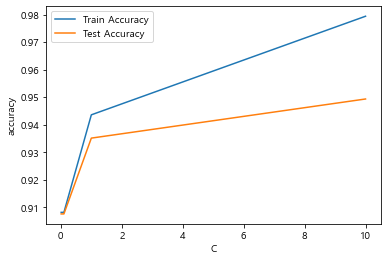

In [56]:
# 모델 정확도 그래프 확인
plt.plot(para_c, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_c, test_accuracy, linestyle="-", label="Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

> C가 1일 때, 모델의 정확도가 많이 증가함  
> 필요시 C 변화 구간을 0.1~1.0 변경하여 정확도 확인 가능


- Gamma: 훈련 샘플이 미치는 영향의 범위를 변경

In [59]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# c: 규제(0.01, 0.1, 1, 10)
para_gamma=[10**gamma for gamma in range(-2, 2)]
#para_gamma=[c*0.1 for c in range(1, 10)]#C 변화 구간 변경

for v_gamma in para_gamma:
    svm=SVC(random_state=1234, C=1, gamma=v_gamma)
    svm.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x, df_test_y))
    
# 결과 저장
df_accuracy_gamma=pd.DataFrame()
df_accuracy_gamma["gamma"]=para_gamma
df_accuracy_gamma["Trainaccuracy"]=train_accuracy
df_accuracy_gamma["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_gamma.round(3)

,gamma,Trainaccuracy,Testaccuracy
0,0.01,0.923,0.920
1,0.10,0.960,0.942
2,1.00,0.996,0.920
3,10.00,1.000,0.908


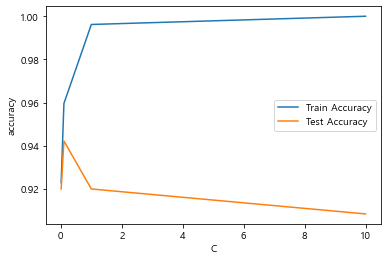

In [60]:
# 모델 정확도 그래프 확인
plt.plot(para_c, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_c, test_accuracy, linestyle="-", label="Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

> gamma가 1 이상이면 train 데이터의 모델은 과대 적합    

> gamma 변화 구간을 변경하여 정확도 확인 가능


In [61]:
# 최종 모델
svc_final=SVC(random_state=1234, gamma=0.1, C=1)
svc_final.fit(df_scaled_train_x, df_train_y)

# 예측
y_pred=svc_final.predict(df_scaled_test_x)
# train 데이터 셋 정확도
print("Accuracy on training set: {0:.3f}\n".format(svc_final.score(df_scaled_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {0:.3f}\n".format(svc_final.score(df_scaled_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.960

Accuracy on test set: 0.942

Confusion matrix: 
[[1021    0]
 [  65   39]]


In [62]:
estimator=SVC(random_state=1234)
# 구하고자 하는 parameter와 범위
param_grid={"C":para_c, "gamma":para_gamma}
# 정확도가 높은 최적 parameter 찾기
grid_rf = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs=-1)
grid_rf.fit(df_scaled_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

best estimator model: 
SVC(C=10, gamma=0.1, random_state=1234)

best parameter: 
{'C': 10, 'gamma': 0.1}

best score: 
0.96


In [63]:
# 최종 모델
svc_final=SVC(random_state=1234, gamma=0.1, C=10)
svc_final.fit(df_scaled_train_x, df_train_y)

# 예측
y_pred=svc_final.predict(df_scaled_test_x)
# train 데이터 셋 정확도
print("Accuracy on training set: {0:.3f}\n".format(svc_final.score(df_scaled_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {0:.3f}\n".format(svc_final.score(df_scaled_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.987

Accuracy on test set: 0.955

Confusion matrix: 
[[1019    2]
 [  49   55]]


# 인공 신경망
아래는 대출자들의 채무 상환과 관련된 데이터이다.  
상환 여부를 예측하기 위한 인공 신경망 분석을 실시하고 결과를 해석하시오.  
- 데이터: HMEQ.CSV(변수: 13게, 자료 수: 3,748개)

In [64]:
df_raw=pd.read_csv("../data/HMEQ.csv")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [65]:
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

> Value는 14개의 결측치, JOB은 81개의 결측치, ... 등을 가짐

In [66]:
# JOB 변수의 결측치는 "Other"로 대체
# inplace: fillna 함수 적용 후 df_raw 데이터에 저장, false면 저장 안함
df_raw["JOB"].fillna("Other", inplace=True)
# 숫자형 변수의 결측치는 해당 변수의 평균값 입력: df_raw.mean() 각 변수별 평균 계산 후 결측치 대체
df_raw.fillna(df_raw.mean(), inplace=True)

In [67]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy=pd.get_dummies(df_raw)
# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [68]:
# 목표변수, 설명변수 데이터 지정
df_raw_y=df_raw_dummy["BAD"]
df_raw_x=df_raw_dummy.drop("BAD", axis=1, inplace=False)

In [69]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (2623, 18)
train data Y size : (2623,)
test data X size : (1125, 18)
test data Y size : (1125,)


In [73]:
nn_uncustomized=MLPClassifier(random_state=1234)
nn_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(nn_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(nn_uncustomized.score(df_test_x, df_test_y)))


Accuracy on training set: 0.722
Accuracy on test set: 0.683


> 모델 정확도는 train 72.2%, test 68.3%로 모델은 train/test 데이터에 대해 과소적합

- Hidden Layer : 은닉층 변경

In [81]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# hidden_layer_sizes: 은닉층 변경 (20, 40, 60, 80, 100, 120, 140, 160)
para_hidden=[20*hidden for hidden in range(1, 9)]

for v_hidden in para_hidden:
    nn=MLPClassifier(random_state=1234, hidden_layer_sizes=v_hidden)
    #nn=MLPClassifier(random_state=1234, hidden_layer_sizes=(v_hidden, v_hidden))
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_hidden=pd.DataFrame()
df_accuracy_hidden["HiddenLayer"]=para_hidden
df_accuracy_hidden["Trainaccuracy"]=train_accuracy
df_accuracy_hidden["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_hidden.round(3)

,HiddenLayer,Trainaccuracy,Testaccuracy
0,20,0.906,0.903
1,40,0.886,0.879
2,60,0.909,0.908
3,80,0.910,0.909
4,100,0.722,0.683
5,120,0.909,0.908
6,140,0.213,0.193
7,160,0.907,0.907


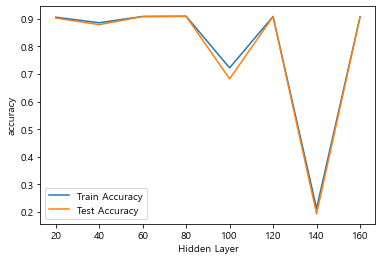

In [82]:
# 모델 정확도 그래프 확인
plt.plot(para_hidden, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_hidden, test_accuracy, linestyle="-", label="Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("Hidden Layer")
plt.legend()

- Activation : 활성화 함수 변경

In [83]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# activation 변경
para_function=["logistic", "tanh", "relu"]

for v_function in para_function:
    nn=MLPClassifier(random_state=1234, activation=v_function)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_function=pd.DataFrame()
df_accuracy_function["ActivationFunction"]=para_function
df_accuracy_function["Trainaccuracy"]=train_accuracy
df_accuracy_function["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_function.round(3)

,ActivationFunction,Trainaccuracy,Testaccuracy
0,logistic,0.908,0.908
1,tanh,0.908,0.908
2,relu,0.722,0.683


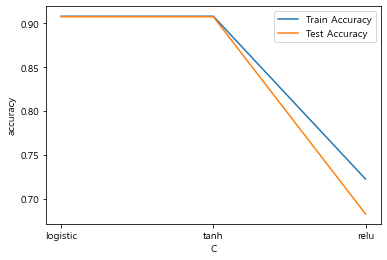

In [84]:
# 모델 정확도 그래프 확인
plt.plot(para_function, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_function, test_accuracy, linestyle="-", label="Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

> "relu" g함수 적용시 모델의 정확도가 상대적으로 낮음.  
> 단, scale 변환 후 모델 성능 비교 필요


- Standardscaler : 설명변수 scale 변경

In [85]:
# 변수명 저장
v_feature_naem=df_train_x.columns
# StandardScaler 적용
scaler = StandardScaler()
df_scaled=scaler.fit_transform(df_raw_x)
df_scaled=pd.DataFrame(df_scaled, columns=v_feature_name)
df_scaled.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
2,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556
3,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,-1.548549,1.548549,2.618672,-0.446497,-0.828257,-0.574064,-0.131804,-0.189556
4,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556


In [86]:
# 데이터 분할
df_scaled_train_x, df_scaled_test=train_test_split(df_scaled, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_scaled_train_x.shape))
print("test data X size : {}".format(df_scaled_test_x.shape))

train data X size : (2623, 18)
test data X size : (1125, 18)


-  scale이 조정된 데이터로 새로운 모델 생성

In [87]:
nn_scaled=MLPClassifier(random_state=1234)
nn_scaled.fit(df_scaled_train_x, df_train_y)
# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(nn_scaled.score(df_scaled_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(nn_scaled.score(df_scaled_test_x, df_test_y)))


Accuracy on training set: 0.971
Accuracy on test set: 0.943


- Hidden Layer : 은닉층 변경

In [88]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# hidden_layer_sizes: 은닉층 변경 (20~240 by 30)
para_hidden=[20*hidden for hidden in range(1, 11)]

for v_hidden in para_hidden:
    #nn=MLPClassifier(random_state=1234, hidden_layer_sizes=v_hidden)
    nn=MLPClassifier(random_state=1234, hidden_layer_sizes=(v_hidden, v_hidden))
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))
    
# 결과 저장
df_accuracy_hidden=pd.DataFrame()
df_accuracy_hidden["HiddenLayer"]=para_hidden
df_accuracy_hidden["Trainaccuracy"]=train_accuracy
df_accuracy_hidden["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_hidden.round(3)

,HiddenLayer,Trainaccuracy,Testaccuracy
0,20,0.975,0.948
1,40,0.994,0.952
2,60,0.999,0.949
3,80,1.000,0.955
4,100,1.000,0.953
5,120,1.000,0.951
6,140,1.000,0.955
7,160,1.000,0.955
8,180,1.000,0.957
9,200,1.000,0.956


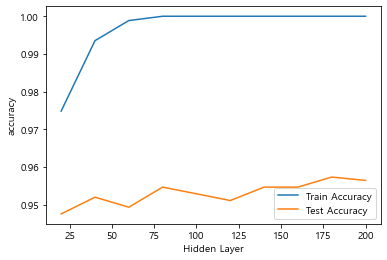

In [89]:
# 모델 정확도 그래프 확인
plt.plot(para_hidden, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_hidden, test_accuracy, linestyle="-", label="Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("Hidden Layer")
plt.legend()

> 은닉층 구조가 복잡할수록 모델 정확도는 향상됨

- Activation : 활성화 함수 변경

In [92]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# activation 변경
para_function=["logistic", "tanh", "relu"]

for v_function in para_function:
    nn=MLPClassifier(random_state=1234, hidden_layer_sizes=(80, 80),activation=v_function)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))
    
# 결과 저장
df_accuracy_function=pd.DataFrame()
df_accuracy_function["ActivationFunction"]=para_function
df_accuracy_function["Trainaccuracy"]=train_accuracy
df_accuracy_function["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_function.round(3)

,ActivationFunction,Trainaccuracy,Testaccuracy
0,logistic,0.937,0.933
1,tanh,0.999,0.952
2,relu,1.000,0.955


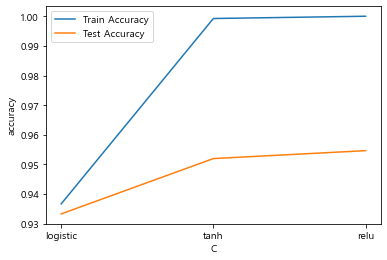

In [93]:
# 모델 정확도 그래프 확인
plt.plot(para_function, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_function, test_accuracy, linestyle="-", label="Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

> "relu" 함수의 모델이 가장 높은 정확도를 보임  
> 특히, 데이터 scaling 영향을 많이 받음

- Slover : 가중치 최적화 변경

In [95]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# activation 변경
para_solver=["lbfgs", "sgd", "adam"]

for v_solver in para_solver:
    nn=MLPClassifier(random_state=1234, solver=v_solver, activation="relu", hidden_layer_sizes=(80, 80))
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))
    
# 결과 저장
df_accuracy_solver=pd.DataFrame()
df_accuracy_solver["Solver"]=para_solver
df_accuracy_solver["Trainaccuracy"]=train_accuracy
df_accuracy_solver["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_solver.round(3)

,Solver,Trainaccuracy,Testaccuracy
0,lbfgs,1.000,0.948
1,sgd,0.934,0.928
2,adam,1.000,0.955


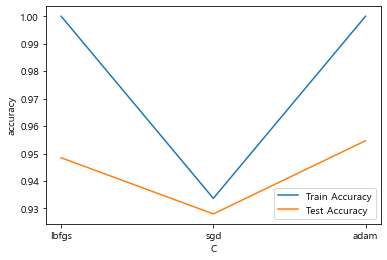

In [97]:
# 모델 정확도 그래프 확인
plt.plot(para_solver, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_solver, test_accuracy, linestyle="-", label="Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()


> "adam" 최적화 모델이 가장 높은 정확도를 보임.  
> 특히 대량 데이터 적용 시 모델의 성능이 우수한 편임

- Mini Batch 변경

In [100]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# Mini Batch 변경
para_batch=[20*batch for batch in range(1, 10)]

for v_batch in para_batch:
    nn=MLPClassifier(random_state=1234, batch_size=v_batch, solver="adam", activation="relu", hidden_layer_sizes=(80, 80))
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))
    
# 결과 저장
df_accuracy_batch=pd.DataFrame()
df_accuracy_batch["Mini Batch"]=para_batch
df_accuracy_batch["Trainaccuracy"]=train_accuracy
df_accuracy_batch["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_batch.round(3)

,Mini Batch,Trainaccuracy,Testaccuracy
0,20,1.0,0.959
1,40,1.0,0.956
2,60,1.0,0.950
3,80,1.0,0.952
4,100,1.0,0.952
5,120,1.0,0.953
6,140,1.0,0.953
7,160,1.0,0.954
8,180,1.0,0.956


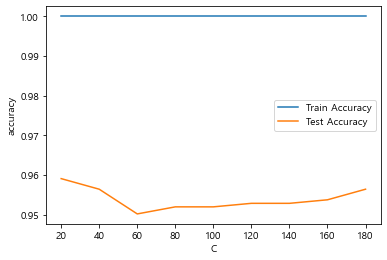

In [101]:
# 모델 정확도 그래프 확인
plt.plot(para_batch, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_batch, test_accuracy, linestyle="-", label="Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()


> train 데이터에는 과적합 경향, test 데이터는 미니 배치 크기가 증가할수록  
> 오차 증가 경향성 있음.

- 최종 모델 선택

In [103]:
# 최종 모델
nn_final=MLPClassifier(random_state=1234, batch_size=100, solver="adam", activation="relu", hidden_layer_sizes=(80, 80))
nn_final.fit(df_scaled_train_x, df_train_y)

# 예측
y_pred=nn_final.predict(df_scaled_test_x)
# train 데이터 셋 정확도
print("Accuracy on training set: {0:.3f}\n".format(nn_final.score(df_scaled_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {0:.3f}\n".format(nn_final.score(df_scaled_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 1.000

Accuracy on test set: 0.952

Confusion matrix: 
[[1018    3]
 [  51   53]]


# KNN
아래는 대출자들의 채무 상환과 관련된 데이터이다.  
상환 여부를 예측하기 위한 KNN 분석을 실시하고 결과를 해석하시오.  
- 데이터: HMEQ.CSV(변수: 13게, 자료 수: 3,748개)

In [105]:
df_raw=pd.read_csv("../data/HMEQ.csv")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [106]:
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

> Value는 14개의 결측치, JOB은 81개의 결측치, ... 등을 가짐

In [107]:
# JOB 변수의 결측치는 "Other"로 대체
# inplace: fillna 함수 적용 후 df_raw 데이터에 저장, false면 저장 안함
df_raw["JOB"].fillna("Other", inplace=True)
# 숫자형 변수의 결측치는 해당 변수의 평균값 입력: df_raw.mean() 각 변수별 평균 계산 후 결측치 대체
df_raw.fillna(df_raw.mean(), inplace=True)

In [108]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy=pd.get_dummies(df_raw)
# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [109]:
# 목표변수, 설명변수 데이터 지정
df_raw_y=df_raw_dummy["BAD"]
df_raw_x=df_raw_dummy.drop("BAD", axis=1, inplace=False)

In [110]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (2623, 18)
train data Y size : (2623,)
test data X size : (1125, 18)
test data Y size : (1125,)


In [112]:
knn_uncustomized=KNeighborsClassifier()
knn_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(knn_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(knn_uncustomized.score(df_test_x, df_test_y)))


Accuracy on training set: 0.916
Accuracy on test set: 0.908


> 모델 정확도는 train 91.6%, test 90.8%로 성능은 유사한 수준이나 다소 과소적합

- 이웃 수 증가에 따른 정확도 변화

In [114]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# 최대 이웃 수 : 1~15
para_n_neighbors=[i for i in range(1, 16)]

for v_n_neighbors in para_n_neighbors:
    knn=KNeighborsClassifier(n_neighbors=v_n_neighbors)
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_n_neighbors=pd.DataFrame()
df_accuracy_n_neighbors["Neighbors"]=para_n_neighbors
df_accuracy_n_neighbors["Trainaccuracy"]=train_accuracy
df_accuracy_n_neighbors["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_n_neighbors.round(3)

,Neighbors,Trainaccuracy,Testaccuracy
0,1,1.000,0.877
1,2,0.928,0.912
2,3,0.929,0.913
3,4,0.916,0.914
4,5,0.916,0.908
5,6,0.913,0.911
6,7,0.913,0.912
7,8,0.910,0.912
8,9,0.911,0.913
9,10,0.909,0.910


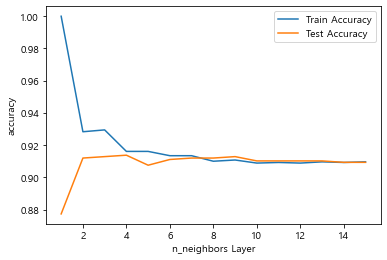

In [116]:
# 모델 정확도 그래프 확인
plt.plot(para_n_neighbors, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_n_neighbors, test_accuracy, linestyle="-", label="Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_neighbors Layer")
plt.legend()

> 군집이 1개일 때 Train 데이터의 정확도는 1  
> 군집이 2개가 되면서 Test 데이터의 정확도가 증가, Train 데이터 정확도 감소

- 가중치별 이웃 수 증가에 따른 정확도 변화

In [121]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# 이웃 수
para_n_neighbors=[i for i in range(1, 11)]*2
# 가중치(uniform, distance)
para_weights=(["uniform"])*10 + (["distance"]*10)

# zip(list1, list2, ...)를 사용하면 list1과 list2의 인덱스별 값을 하나씩 가져옴
# 1번 loop: n_neighbors=para_n_neighbors[0], weights=para_weights[0]
# 2번 loop: n_neighbors=para_n_neighbors[1], weights=para_weights[1]
for (v_n_neighbors, v_weights) in zip(para_n_neighbors, para_weights):
    knn=KNeighborsClassifier(n_neighbors=v_n_neighbors, weights=v_weights)
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_weights=pd.DataFrame()
df_accuracy_weights["Neighbors"]=para_n_neighbors
df_accuracy_weights["Weights"]=para_weights
df_accuracy_weights["TrainAccuracy"]=train_accuracy
df_accuracy_weights["TestAccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_weights.round(3)

,Neighbors,Weights,TrainAccuracy,TestAccuracy
0,1,uniform,1.000,0.877
1,2,uniform,0.928,0.912
2,3,uniform,0.929,0.913
3,4,uniform,0.916,0.914
4,5,uniform,0.916,0.908
5,6,uniform,0.913,0.911
6,7,uniform,0.913,0.912
7,8,uniform,0.910,0.912
8,9,uniform,0.911,0.913
9,10,uniform,0.909,0.910


In [122]:
# 그림을 그리기 위해 데이터의 형태를 변환
df_accuracy_weights_pivot=df_accuracy_weights.pivot(index="Neighbors", columns="Weights", values=["TrainAccuracy", "TestAccuracy"])
df_accuracy_weights_pivot                                                                            

TrainAccuracy           TestAccuracy          
Weights        distance   uniform     distance   uniform
Neighbors                                               
1                   1.0  1.000000     0.877333  0.877333
2                   1.0  0.928326     0.877333  0.912000
3                   1.0  0.929470     0.912000  0.912889
4                   1.0  0.916127     0.913778  0.913778
5                   1.0  0.916127     0.912889  0.907556
6                   1.0  0.913458     0.912889  0.911111
7                   1.0  0.913458     0.912889  0.912000
8                   1.0  0.910027     0.913778  0.912000
9                   1.0  0.910789     0.914667  0.912889
10                  1.0  0.908883     0.914667  0.910222

In [123]:
# pivot을 이용할 경우, columns와 values이 2개의 level로 이루어지므로 하나의 level로 변환
level0=df_accuracy_weights_pivot.columns.get_level_values(0)
level1=df_accuracy_weights_pivot.columns.get_level_values(1)
df_accuracy_weights_pivot.columns=level0+"_"+level1
df_accuracy_weights_pivot.head()

,TrainAccuracy_distance,TrainAccuracy_uniform,TestAccuracy_distance,TestAccuracy_uniform
Neighbors,,,,
1,1.0,1.000000,0.877333,0.877333
2,1.0,0.928326,0.877333,0.912000
3,1.0,0.929470,0.912000,0.912889
4,1.0,0.916127,0.913778,0.913778
5,1.0,0.916127,0.912889,0.907556


- 가중치별 이웃 수 증가에 따른 정확도 변화

<AxesSubplot:xlabel='Neighbors'>

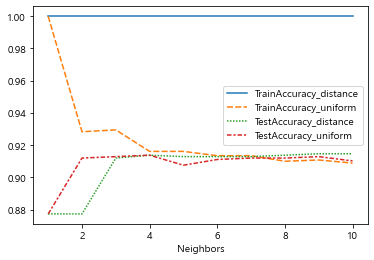

In [127]:
# 그래프 생성. 변수별 linestyle 구분
sns.lineplot(data=df_accuracy_weights_pivot)

> 가중치 distance알 때 train 데이터의 모델 정확도는 1(과대적합)

- 거리 계산 방법별 이웃 수 증가에 따른 정확도 변화

In [128]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# 이웃 수
para_n_neighbors=[i for i in range(1, 11)]*3
# 거리 계산 방법(minkowski, euclidean, manhattan)
para_metric=["minkowski"]*10 + ["euclidean"]*10+["manhattan"]*10

# zip(list1, list2, ...)를 사용하면 list1과 list2의 인덱스별 값을 하나씩 가져옴
# 1번 loop: n_neighbors=para_n_neighbors[0], metric=para_metric[0]
# 2번 loop: n_neighbors=para_n_neighbors[1], metric=para_metric[1]
for (v_n_neighbors, v_metric) in zip(para_n_neighbors, para_metric):
    knn=KNeighborsClassifier(n_neighbors=v_n_neighbors, metric=v_metric, weights="uniform")
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_metric=pd.DataFrame()
df_accuracy_metric["Neighbors"]=para_n_neighbors
df_accuracy_metric["Metric"]=para_metric
df_accuracy_metric["TrainAccuracy"]=train_accuracy
df_accuracy_metric["TestAccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_metric.round(3)

,Neighbors,Metric,TrainAccuracy,TestAccuracy
0,1,minkowski,1.000,0.877
1,2,minkowski,0.928,0.912
2,3,minkowski,0.929,0.913
3,4,minkowski,0.916,0.914
4,5,minkowski,0.916,0.908
5,6,minkowski,0.913,0.911
6,7,minkowski,0.913,0.912
7,8,minkowski,0.910,0.912
8,9,minkowski,0.911,0.913
9,10,minkowski,0.909,0.910


<AxesSubplot:xlabel='Neighbors'>

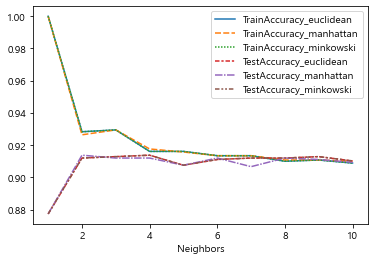

In [129]:
# 정확도를 그래프로 그림
df_accuracy_metric_pivot=df_accuracy_metric.pivot(index="Neighbors", columns="Metric", values=["TrainAccuracy", "TestAccuracy"])

level0=df_accuracy_metric_pivot.columns.get_level_values(0)
level1=df_accuracy_metric_pivot.columns.get_level_values(1)
df_accuracy_metric_pivot.columns=level0+"_"+level1

sns.lineplot(data=df_accuracy_metric_pivot)

> 거리 계산 방법 별 정확도의 차이거 없음

- 결론 도출

In [130]:
# 최종 모델
knn_final=KNeighborsClassifier(n_neighbors=4, weights="uniform", metric="euclidean")
knn_final.fit(df_train_x, df_train_y)

# 예측
y_pred=knn_final.predict(df_test_x)
# train 데이터 셋 정확도
print("Accuracy on training set: {0:.3f}\n".format(knn_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {0:.3f}\n".format(knn_final.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.916

Accuracy on test set: 0.914

Confusion matrix: 
[[1018    3]
 [  94   10]]


> - 예측 정확도 : 0.914
> - 이웃 수 : 4
> - 가중치 : 균일(uniform)
> - 거리계산 : 차이 없음

#  모델 평가
아래는 대출자들의 채무 상환과 관련된 데이터이다.  
상환 여부를 예측/분류하는 복수의 분류 모델을 실행하고   
각 모델별 분류 정확도를 오분류율 기준으로 평가하시오.
- 데이터: HMEQ.CSV(변수: 13개, 자료 수: 3,748개)
- 모델: 의사결정 트리, Random Forest, Gradient Boost, 인공 신경망

In [133]:
df_raw=pd.read_csv("../data/HMEQ.csv")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [134]:
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

> Value는 14개의 결측치, JOB은 81개의 결측치, ... 등을 가짐

In [135]:
# JOB 변수의 결측치는 "Other"로 대체
# inplace: fillna 함수 적용 후 df_raw 데이터에 저장, false면 저장 안함
df_raw["JOB"].fillna("Other", inplace=True)
# 숫자형 변수의 결측치는 해당 변수의 평균값 입력: df_raw.mean() 각 변수별 평균 계산 후 결측치 대체
df_raw.fillna(df_raw.mean(), inplace=True)

In [136]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy=pd.get_dummies(df_raw)
# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [137]:
# 목표변수, 설명변수 데이터 지정
df_raw_y=df_raw_dummy["BAD"]
df_raw_x=df_raw_dummy.drop("BAD", axis=1, inplace=False)

In [138]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (2623, 18)
train data Y size : (2623,)
test data X size : (1125, 18)
test data Y size : (1125,)


- 평가 저장

In [159]:
# 분석 모델
model=["DecisionTree", "RandomForest", "GradientBoosting", "NeuralNet", "KNN", "SVM"]

# 정확도 저장
train_accuracy=[]; test_accuracy=[]
# f1 score 저장
model_f1_score=[]
# auc score 저장
model_auc=[]

- 의사결정나무

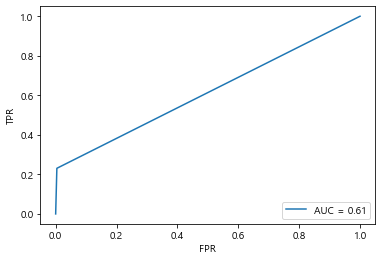

In [160]:
# 모델 생성
dt_model=DecisionTreeClassifier(max_depth=4, min_samples_leaf=30)
dt_model.fit(df_train_x, df_train_y)

# train 정확도
train_accuracy.append(dt_model.score(df_train_x, df_train_y))
# test 정확도
test_accuracy.append(dt_model.score(df_test_x, df_test_y))

# 예측값
y_pred=dt_model.predict(df_test_x)

# roc_curve(실제값, 예측값), fpr=FP/(FP+TN): 거짓 양성 비율, tpr=TP/(TP+FN):진짜 양성 비율(재현율)
fpr, tpr, thresholds=roc_curve(df_test_y, y_pred)
roc_auc=auc(fpr, tpr)

# auc 저장
model_auc.append(roc_auc)

# roc curve 그리기, label에 auc 표시(소수점 2자리)
plt.plot(fpr, tpr, label="AUC = %0.2f"%roc_auc)
plt.legend(loc="lower right")
plt.ylabel("TPR");plt.xlabel("FPR")
plt.show()

In [161]:
# f1 스코어
model_f1_score.append(f1_score(df_test_y, y_pred))

- 랜덤 포레스트

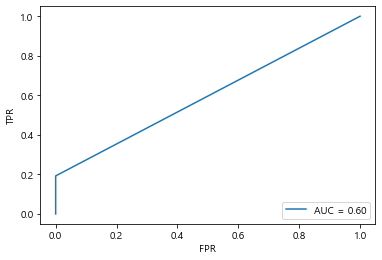

In [162]:
# 모델 생성
rf_model=RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_leaf=20, random_state=1234)
rf_model.fit(df_train_x, df_train_y)

# train 정확도
train_accuracy.append(rf_model.score(df_train_x, df_train_y))
# test 정확도
test_accuracy.append(rf_model.score(df_test_x, df_test_y))

# 예측값
y_pred=rf_model.predict(df_test_x)

# roc_curve(실제값, 예측값), fpr=FP/(FP+TN): 거짓 양성 비율, tpr=TP/(TP+FN):진짜 양성 비율(재현율)
fpr, tpr, thresholds=roc_curve(df_test_y, y_pred)
roc_auc=auc(fpr, tpr)

# auc 저장
model_auc.append(roc_auc)

# roc curve 그리기, label에 auc 표시(소수점 2자리)
plt.plot(fpr, tpr, label="AUC = %0.2f"%roc_auc)
plt.legend(loc="lower right")
plt.ylabel("TPR");plt.xlabel("FPR")
plt.show()

In [163]:
# f1 스코어
model_f1_score.append(f1_score(df_test_y, y_pred))

- 그래디언트 부스팅

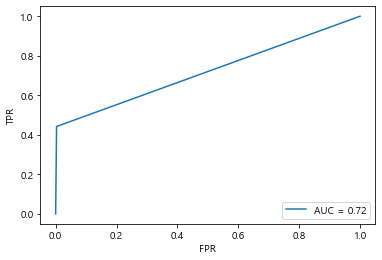

In [164]:
# 모델 생성
gb_model=GradientBoostingClassifier(random_state=1234, n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=10)
gb_model.fit(df_train_x, df_train_y)

# train 정확도
train_accuracy.append(gb_model.score(df_train_x, df_train_y))
# test 정확도
test_accuracy.append(gb_model.score(df_test_x, df_test_y))

# 예측값
y_pred=gb_model.predict(df_test_x)

# roc_curve(실제값, 예측값), fpr=FP/(FP+TN): 거짓 양성 비율, tpr=TP/(TP+FN):진짜 양성 비율(재현율)
fpr, tpr, thresholds=roc_curve(df_test_y, y_pred)
roc_auc=auc(fpr, tpr)

# auc 저장
model_auc.append(roc_auc)

# roc curve 그리기, label에 auc 표시(소수점 2자리)
plt.plot(fpr, tpr, label="AUC = %0.2f"%roc_auc)
plt.legend(loc="lower right")
plt.ylabel("TPR");plt.xlabel("FPR")
plt.show()

In [165]:
# f1 스코어
model_f1_score.append(f1_score(df_test_y, y_pred))

- 설명변수 scaling

In [166]:
# 변수명 저장
v_feature_names=df_train_x.columns

# StandardScaler 적용
scaler=StandardScaler()
df_scaled=scaler.fit_transform(df_raw_x)
df_scaled=pd.DataFrame(df_scaled, columns=v_feature_names)

# 데이터 분할
df_scaled_train_x, df_scaled_test_x=train_test_split(df_scaled, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("test data X size : {}".format(df_test_x.shape))

train data X size : (2623, 18)
test data X size : (1125, 18)


- 인공 신경망

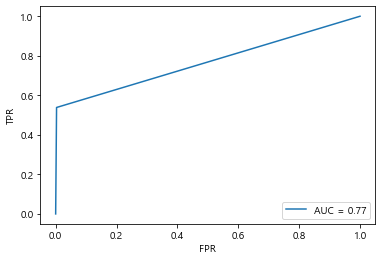

In [167]:
# 모델 생성
nn_model=MLPClassifier(random_state=1234, hidden_layer_sizes=(80, 80), activation="relu", solver="adam")
nn_model.fit(df_scaled_train_x, df_train_y)

# train 정확도
train_accuracy.append(nn_model.score(df_scaled_train_x, df_train_y))
# test 정확도
test_accuracy.append(nn_model.score(df_scaled_test_x, df_test_y))

# 예측값
y_pred=nn_model.predict(df_scaled_test_x)

# roc_curve(실제값, 예측값), fpr=FP/(FP+TN): 거짓 양성 비율, tpr=TP/(TP+FN):진짜 양성 비율(재현율)
fpr, tpr, thresholds=roc_curve(df_test_y, y_pred)
roc_auc=auc(fpr, tpr)

# auc 저장
model_auc.append(roc_auc)

# roc curve 그리기, label에 auc 표시(소수점 2자리)
plt.plot(fpr, tpr, label="AUC = %0.2f"%roc_auc)
plt.legend(loc="lower right")
plt.ylabel("TPR");plt.xlabel("FPR")
plt.show()

In [168]:
# f1 스코어
model_f1_score.append(f1_score(df_test_y, y_pred))

- KNN

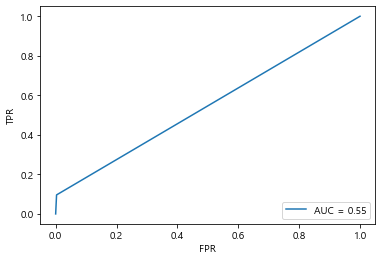

In [169]:
# 모델 생성
knn_model=KNeighborsClassifier(n_neighbors=4, weights="uniform", metric="euclidean")
knn_model.fit(df_train_x, df_train_y)

# train 정확도
train_accuracy.append(knn_model.score(df_train_x, df_train_y))
# test 정확도
test_accuracy.append(knn_model.score(df_test_x, df_test_y))

# 예측값
y_pred=knn_model.predict(df_test_x)

# roc_curve(실제값, 예측값), fpr=FP/(FP+TN): 거짓 양성 비율, tpr=TP/(TP+FN):진짜 양성 비율(재현율)
fpr, tpr, thresholds=roc_curve(df_test_y, y_pred)
roc_auc=auc(fpr, tpr)

# auc 저장
model_auc.append(roc_auc)

# roc curve 그리기, label에 auc 표시(소수점 2자리)
plt.plot(fpr, tpr, label="AUC = %0.2f"%roc_auc)
plt.legend(loc="lower right")
plt.ylabel("TPR");plt.xlabel("FPR")
plt.show()

In [170]:
# f1 스코어
model_f1_score.append(f1_score(df_test_y, y_pred))

- SVM

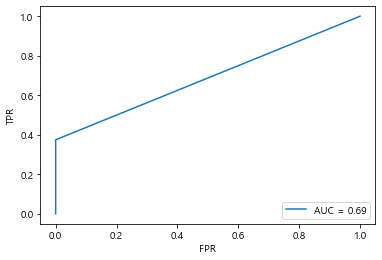

In [171]:
# 모델 생성
svc_model=SVC(random_state=1234, gamma=0.1, C=1)
svc_model.fit(df_scaled_train_x, df_train_y)

# train 정확도
train_accuracy.append(svc_model.score(df_scaled_train_x, df_train_y))
# test 정확도
test_accuracy.append(svc_model.score(df_scaled_test_x, df_test_y))

# 예측값
y_pred=svc_model.predict(df_scaled_test_x)

# roc_curve(실제값, 예측값), fpr=FP/(FP+TN): 거짓 양성 비율, tpr=TP/(TP+FN):진짜 양성 비율(재현율)
fpr, tpr, thresholds=roc_curve(df_test_y, y_pred)
roc_auc=auc(fpr, tpr)

# auc 저장
model_auc.append(roc_auc)

# roc curve 그리기, label에 auc 표시(소수점 2자리)
plt.plot(fpr, tpr, label="AUC = %0.2f"%roc_auc)
plt.legend(loc="lower right")
plt.ylabel("TPR");plt.xlabel("FPR")
plt.show()

In [172]:
# f1 스코어
model_f1_score.append(f1_score(df_test_y, y_pred))

- 모델별 정확도 표, bar plot 생성

In [173]:
# 모델별 정확도 표
df_eval=pd.DataFrame(index=model)
df_eval["TrainAccuracy"]=train_accuracy
df_eval["TestAccuracy"]=test_accuracy
df_eval["F1Score"]=model_f1_score
df_eval["AUC"]=model_auc
df_eval.round(3)

,TrainAccuracy,TestAccuracy,F1Score,AUC
DecisionTree,0.930,0.925,0.364,0.613
RandomForest,0.927,0.925,0.323,0.596
GradientBoosting,0.977,0.946,0.601,0.720
NeuralNet,1.000,0.955,0.687,0.768
KNN,0.916,0.914,0.171,0.547
SVM,0.960,0.942,0.545,0.688


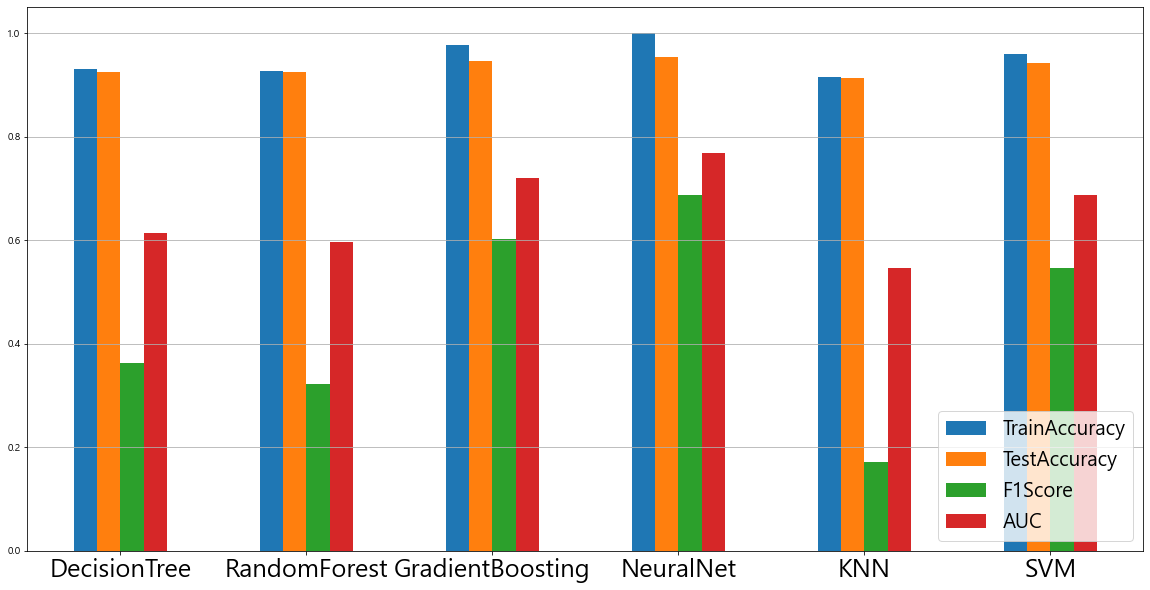

In [181]:
# 정확도 bar plot 생성
df_eval.plot.bar(rot=0, figsize=(20, 10))
plt.legend(loc="lower right", fontsize=20)
plt.xticks(fontsize=25)
plt.grid(axis="y")

> 인공 신경망 모델이 가장 높은 정확도와 F1 score, AUC를 보임  

> NeuraNet > GradientBoosting > SVM > DecisionTree > RandomForest > KNN